# Third Assignment

##MSc course in Artificial Intelligence

**Simone Mugnai**

In [1]:
# !rm -r AI_USI_MA/
!git clone https://github.com/UmbertoJr/AI_USI_MA.git

fatal: destination path 'AI_USI_MA' already exists and is not an empty directory.


name: eil76
nPoints: 76
best_sol: 538.0


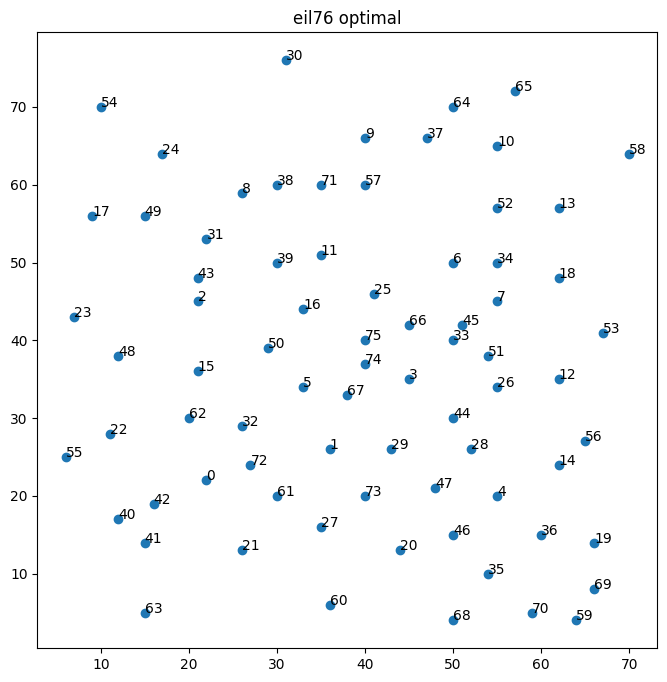

In [2]:
# Imports

from AI_USI_MA.IO_manager.io_tsp import TSP_Instance_Creator
# if you are running from your local remove the prefix AI2020 (comment the previous line and uncomment the following line)
# from IO_manager.io_tsp import TSP_Instance_Creator

ic = TSP_Instance_Creator("standard", 'eil76.tsp')
ic.print_info()
ic.plot_data()

name: ch130
nPoints: 130
best_sol: 6110.0


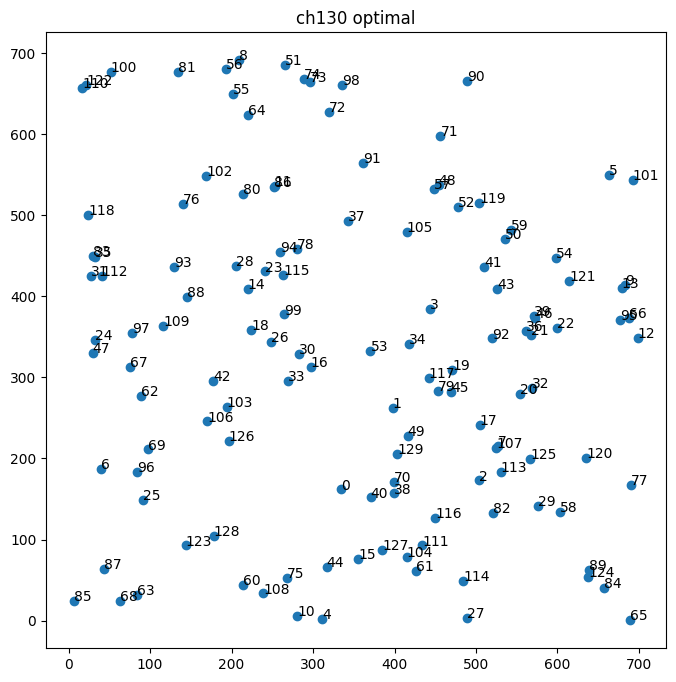

6110.0

In [3]:
ic = TSP_Instance_Creator("standard", 'ch130.tsp')
ic.print_info()
ic.plot_data()
ic.best_sol

name: d198
nPoints: 198
best_sol: 15780.0


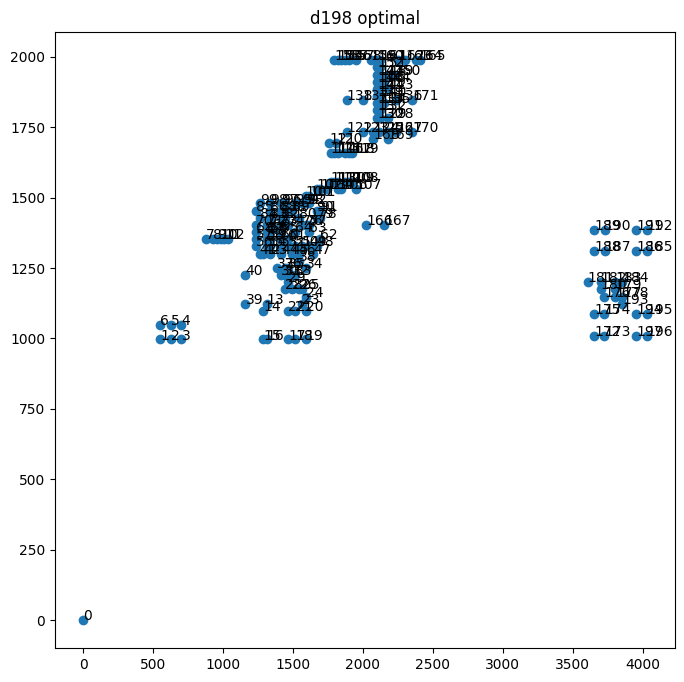

In [4]:
ic = TSP_Instance_Creator("standard", 'd198.tsp')
ic.print_info()
ic.plot_data()


name: myTSP_dim10
nPoints: 10
best_sol: 2732.0


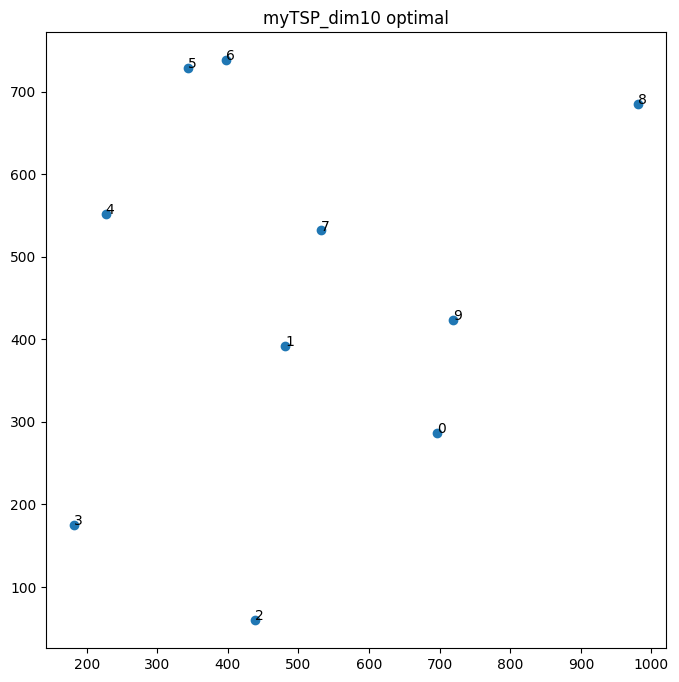

In [5]:
ic = TSP_Instance_Creator("standard", 'myTSP_dim10.tsp')
ic.print_info()
ic.plot_data()

In [6]:
import numpy as np
from time import time
from AI_USI_MA.solvers.local_search import twoOpt
from AI_USI_MA.solvers.constructive_algorithms import nn
from AI_USI_MA.solvers.constructive_algorithms import compute_length

# nn takes as input the distance matrix and returns
# the tour and the length constructed with nearest neighbor, i.e.   tour, len_t = nn(dist_mat)

# twoOpt takes as input the solution, the actual_len and the distance matrix
# and returns the tour and the length created with 2-opt, i.e.     tour, lent_t = twoOpt(solution, actual_len, dist_mat)

class ACS:
  m = 10
  beta = 2
  alpha = rho = 0.1
  cl =  15
  @staticmethod
  def take_candidates(j, dist_mat):
    return list(np.argsort(dist_mat[j])[1:ACS.cl+1])

  def __init__(self, instance,use_cl=False):
    #Initialization of parameters and data structures
    # This section initializes various parameters and data structures needed for the Ant Colony System algorithm.
    # Parameters such as m, beta, alpha, rho, and cl are set as class attributes, and key data structures like
    # position, tour, pheromone, and eta are initialized for each ant in the colony.
    self.std_deviation = None
    self.iteration = 0
    self.best_cost = float('inf')
    self.best_tours_generated = 0
    self.cost = float('inf')
    self.n = instance.nPoints
    self.all_candidates =list(range(instance.nPoints))
    self.dist_mat = instance.dist_matrix
    _, self.L_nn = nn(instance.dist_matrix, starting_node=np.random.choice(self.n))
    self.tau0 = 1./(float(self.n) * self.L_nn)
    self.position = {i: None for i in range(ACS.m)}  # position collector for the Ants, TO BE UPDATED during the steps
    self.tour = {i: [] for i in range(ACS.m)}  # tour collector for the Ants
    self.pheromone = {r: [self.tau0]*ACS.cl for r in range(self.n)}
    if use_cl:
      nn_tour, _ = nn(instance.dist_matrix, starting_node=np.random.choice(self.n))
      self.candidate_list = nn_tour
    else:
      self.candidate_list = {r: self.take_candidates(r, instance.dist_matrix) for r in range(self.n)}
    self.eta = {r: [1/self.dist_mat[r, s] for s in ACS.take_candidates(r, instance.dist_matrix)] for r in range(self.n)}
    # The candidate list for each node is generated either using the nearest neighbor heuristic or
    # through the take_candidates method. This list is crucial for ants to choose their next nodes during
    # the construction of tours. If use_cl is True, the nearest neighbor tour is used; otherwise, candidate
    # lists are generated based on the take_candidates method, considering a fixed number of candidates (ACS.cl).

  def run_acs(self,max_time,q0,use_2_opt=True):
    # This method runs the Ant Colony System algorithm for a specified maximum time, updating solutions iteratively.
    # It constructs solutions for each ant, performs local pheromone updates, and optionally applies the 2-opt optimization.
    # The global pheromone is updated after all ants complete their tours, and the best solution is tracked throughout.
    if q0 == "adjustive":
      q0 = (1 -( 13 / self.n))

    start_time = time()
    all_costs = []
    while (time() - start_time) < max_time:
      # For each ant in the colony, a solution is constructed using the construct_solution method,
      # followed by local pheromone update and optionally applying the 2-opt optimization.
      # The global pheromone is then updated, and the best solution is updated if a better one is found.

      self.iteration += 1
      for ant in range(ACS.m):
        self.construct_solution(ant,q0)
        self.local_pheromone_update(ant)
        self.apply_2_opt(ant)

      self.global_pheromone_update()
      current_solution = min(self.tour.values(), key=lambda x: compute_length(x, self.dist_mat))
      current_cost = compute_length(current_solution, self.dist_mat)
      all_costs.append(current_cost)

      # Update best solution if necessary
      if current_cost < self.best_cost:
          self.best_solution = current_solution.copy()
          self.best_cost = current_cost
          self.best_tours_generated = self.iteration
      self.std_deviation = np.std(all_costs) if len(all_costs) > 1 else 0



  def construct_solution(self,ant,q0):
    # Constructs a solution for a given ant,
    #selecting next nodes based on the choose_next_node method and updating the tour and ant's position accordingly.
    current_node = np.random.choice(self.n)
    self.position_ant = current_node
    self.tour[ant] = [current_node]
    for _ in range(self.n-1):
      next_node = self.choose_next_node(ant,current_node,q0)

      self.position[ant] = next_node
      self.tour[ant].append(next_node)
      current_node = next_node

  def choose_next_node(self, ant, current_node,q0):
    # Selects the next node for an ant, either through exploitation by choosing the node with maximum probability (with probability q0),
    # or exploration by randomly choosing a node based on calculated probabilities.
    visited_nodes = set(self.tour[ant])
    available_candidates = [node for node in self.all_candidates if node not in visited_nodes]


    if np.random.rand() < q0:
        # Exploitation: Choose the next node with the maximum probability
        probabilities = self.calculate_probabilities(ant, current_node)
        next_node = available_candidates[np.argmax(probabilities)]
    else:
        # Exploration: Choose the next node based on probabilities
        probabilities = self.calculate_probabilities(ant, current_node)
        next_node = np.random.choice(available_candidates, p=probabilities)
    return next_node


  def apply_2_opt(self, ant):
    #apply two-opt if enabled
    tour, len_t = twoOpt(self.tour[ant], compute_length(self.tour[ant], self.dist_mat), self.dist_mat)
    self.tour[ant] = tour


  def calculate_probabilities(self, ant, current_node):
    # Calculates the probabilities for selecting available candidate nodes based on pheromone levels and heuristic information,
    # ensuring proper handling of array lengths to match the number of available candidates.
    visited_nodes = set(self.tour[ant])
    available_candidates = [node for node in self.all_candidates if node not in visited_nodes]
    pheromone_values = np.power(self.pheromone[current_node], ACS.beta)
    eta_values = np.power(self.eta[current_node], ACS.alpha)
    probabilities = (pheromone_values * eta_values) / np.sum(pheromone_values * eta_values)

    if len(probabilities) < len(available_candidates):
      padding_length = len(available_candidates) - len(probabilities)
      probabilities = np.concatenate((probabilities, np.zeros(padding_length)))

    if len(probabilities) > len(available_candidates):
        probabilities = probabilities[:len(available_candidates)]
        probabilities /= np.sum(probabilities)

    return probabilities

  def local_pheromone_update(self, ant):
    # Performs local pheromone update on the edges traversed by an ant in its tour, ensuring evaporation and depositing a constant amount of pheromone.
    for i in range(self.n - 1):
        current_node = self.tour[ant][i]
        next_node = self.tour[ant][(i + 1) % self.n]
        next_node_index = next_node % ACS.cl
        if current_node < self.n and next_node < self.n:
            self.pheromone[current_node][next_node_index] = (1 - ACS.rho) * self.pheromone[current_node][next_node_index] + ACS.rho * self.tau0
        else:
            print("Out of range indices:", current_node, next_node)
            print("Tour:", self.tour[ant])
            print("Dimensions:", self.n, ACS.cl)

  def global_pheromone_update(self):
    # Updates global pheromone levels on all edges, performing evaporation by multiplying existing pheromones with (1 - ACS.rho).
    for r in range(self.n):
        self.pheromone[r] = [val * (1 - ACS.rho) for val in self.pheromone[r]]






## Create a DataFrame
Report the results achieved by testing the algorithm on 3 differents instances -all of small-size- with different values of q0 and different approaches, mainly the Two-opt optimitation -always implemented- and the use of the Candidate List.



In [7]:
import pandas as pd
from IPython.display import IFrame, HTML
seeds = [0, 123, 333]
max_time = 180  # in seconds
q0_values = [0.5, 0.98,"adjustive"] # adjustive is equal to (1-(13/instance.nPoints))
cost_sol_ACS_base = []
cost_sol_twoopt = []
cost_sol_cl = []
instances = ["eil76.tsp", "ch130.tsp", "d198.tsp"]
use_cl= [True,False]
results = []
gaps = []
# Evaluates Ant Colony System (ACS) algorithm performance on multiple instances with varying parameters, including q0, using candidate lists (CL) or not.
# Records solution quality, number of iterations, and gap percentage compared to the best-known solution for each combination of parameters.
for seed in seeds:
  for q0 in q0_values:
    for inst_name in instances:
      for cl in use_cl:
        ic = TSP_Instance_Creator("standard", inst_name)
        acs = ACS(ic,cl)
        np.random.seed(seed)
        acs.run_acs(max_time, q0,use_2_opt=True)
        best_known_sol = ic.best_sol
        current_sol = acs.best_cost
        num_iteration = acs.iteration
        best_iteration = acs.best_tours_generated
        std_dev = acs.std_deviation
        # Calculate gap
        gap = ((current_sol - best_known_sol) / best_known_sol) * 100

        # Append results to lists
        results.append({
            'Instance': inst_name,
            'Seed': seed,
            'q0': q0,
            'Use_CL': cl,
            'Best_Solution': current_sol,
            'Number Iterations': num_iteration,
            'Best_Solution_iter': best_iteration,
            'Standard Deviation': std_dev,
            'Gap%': gap
        })



# Create a DataFrame from the results
df = pd.DataFrame(results)

# Define a  ordering for instances
custom_order = ['eil76.tsp', 'ch130.tsp', 'd198.tsp']

# Add a new column for  sorting
df['Instance_Order'] = df['Instance'].apply(lambda x: custom_order.index(x) if x in custom_order else len(custom_order))

# Sort the DataFrame by 'Instance_Order'
df = df.sort_values(by=['Instance_Order'])

df = df.drop(columns=['Instance_Order'])

min_indices = df.groupby('Instance')['Best_Solution'].idxmin()
df = df.reset_index(drop=True)

# Display the DataFrame
styled_df = (
    df.style
    .format({
        'Best_Solution': '{:.2f}',  # Format Best_Solution column to two decimal places
        'Gap%': '{:.2f}%',  # Format Gap% column as percentage with two decimal places
        'Standard Deviation': '{:.2f}',  # Format Standard Deviation column to two decimal places
    })
    .bar(subset=['Gap%'], color='lightgreen', vmin=0, vmax=100)  # Apply a green bar for the Gap% column
    .apply(lambda x: ['background-color: lightblue' if x.name in min_indices.values else '' for _ in x], axis=1, subset=['Best_Solution'])  # Highlight the minimum value in the Best_Solution column for each instance separately
    .highlight_max('Standard Deviation', color='lightcoral')  # Highlight the maximum value in the Standard Deviation column
    #.set_properties(subset=['Number Iterations', 'Best_Solution_iter'], **{'background-color': 'lightyellow'})  # Set a light yellow background for specific columns, removed due problem with dark mod
)

# Display the styled DataFrame
styled_df.to_html('styled_acs_table.html', escape=False)  # Save the styled table as an HTML file
html_path = 'styled_acs_table.html'

# Use the HTML class to display the results
HTML(filename=html_path)







,Instance,Seed,q0,Use_CL,Best_Solution,Number Iterations,Best_Solution_iter,Standard Deviation,Gap%
0,eil76.tsp,0,0.500000,True,547.00,194,140,6.04,1.67%
1,eil76.tsp,123,0.980000,True,546.00,196,164,5.72,1.49%
2,eil76.tsp,123,adjustive,True,547.00,192,57,5.73,1.67%
3,eil76.tsp,123,adjustive,False,547.00,197,57,5.81,1.67%
4,eil76.tsp,123,0.500000,False,547.00,197,141,6.02,1.67%
5,eil76.tsp,123,0.500000,True,547.00,192,141,5.95,1.67%
6,eil76.tsp,333,0.500000,True,548.00,196,128,6.26,1.86%
7,eil76.tsp,333,0.500000,False,554.00,192,71,5.20,2.97%
8,eil76.tsp,123,0.980000,False,549.00,200,113,5.61,2.04%
9,eil76.tsp,0,adjustive,True,544.00,193,166,5.96,1.12%


## **Results Interpretation**

The table provides insightful observations on the performance of the **Ant Colony System (ACS)** algorithm across different instances of the Traveling Salesman Problem (TSP), considering various parameters.

### **Candidate List (CL)**

The introduction of the candidate list is effective. Despite a slight increase in the average gap, the algorithm benefits from a smoother trajectory, enabling more iterations within the specified time constraints. This trade-off showcases the effectiveness of **CL** in refining the solution space exploration.

### **q0 (Exploration-Exploitation Tradeoff)**

The choice of the exploration-exploitation parameter, **q0**, significantly influences the algorithm's performance. As anticipated, smaller **q0** values, emphasizing exploitation over exploration, lead to better outcomes. This allows for an efficient search within the solution space, resulting in improved solutions. <br>
-For further clarification, the value of qo = "adjustive" refers to a value depending on the instance, that is equal to (1-(13/instance_points))-
### **Standard Deviation**

The standard deviation exhibits a noticeable increase with larger problem sizes, which is expected. However, it remains relatively consistent across instances. The variation in standard deviation is also influenced by the choice of **q0**, emphasizing the impact of the exploration strategy on the algorithm's convergence behavior.

### **Final Remarks**

Given that the experiment focused on small-sized problems, extending the analysis to larger problem instances would serve as a robust benchmark for the algorithm. Additionally, the incorporation of the 2-opt optimization technique, while not explicitly included in this analysis, significantly contributed to solution improvement.

In conclusion, the experiment achieved its objectives, demonstrating the effectiveness of the **ACS** algorithm in solving TSP instances. Further exploration with larger problem sizes and additional optimization techniques could provide a more comprehensive understanding of the algorithm's capabilities and limitations.




# **Average and Best Gap% over Iterations**

The series of plots illustrate the performance of the Ant Colony System (ACS) algorithm on three different instances of the Traveling Salesman Problem (TSP). Each plot focuses on a specific TSP instance: `eil76.tsp`, `ch130.tsp`, and `d198.tsp`. The x-axis represents the number of iterations, while the y-axis represents the percentage gap (% Gap) between the algorithm's solution and the best-known solution.

## eil76.tsp

The first plot showcases the algorithm's behavior on the `eil76.tsp` instance. The blue line represents the average gap% over iterations, providing insights into the algorithm's convergence. Additionally, red 'X' markers highlight specific iterations where the algorithm achieved the best gap% for the given instance.

## ch130.tsp

The second plot focuses on the `ch130.tsp` instance. Similar to the first plot, it depicts the average gap% over iterations with red 'X' markers denoting the iterations with the best gap%.

## d198.tsp

The third plot examines the algorithm's performance on the `d198.tsp` instance. As in the previous plots, the blue line indicates the average gap% over iterations, while red 'X' markers pinpoint iterations with the best gap% for this specific instance.

In all three plots, the visualization provides a clear understanding of how the algorithm converges over iterations and highlights key points where it achieves the best gap% for each TSP instance. These insights can be valuable for analyzing the algorithm's efficiency and identifying optimal parameters for future implementations.

---

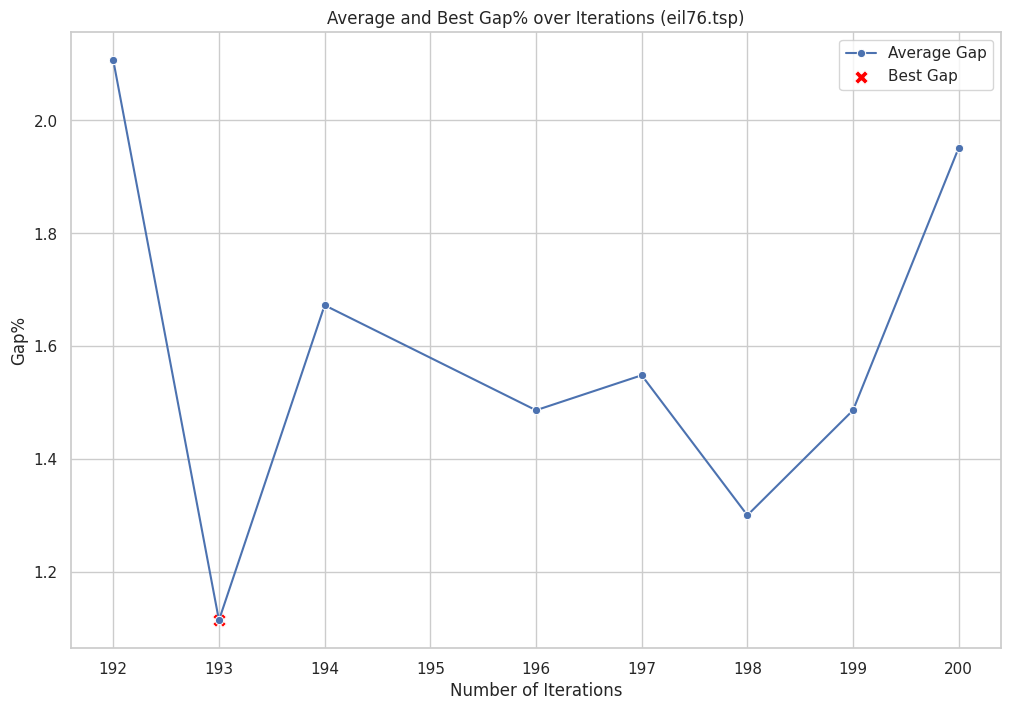

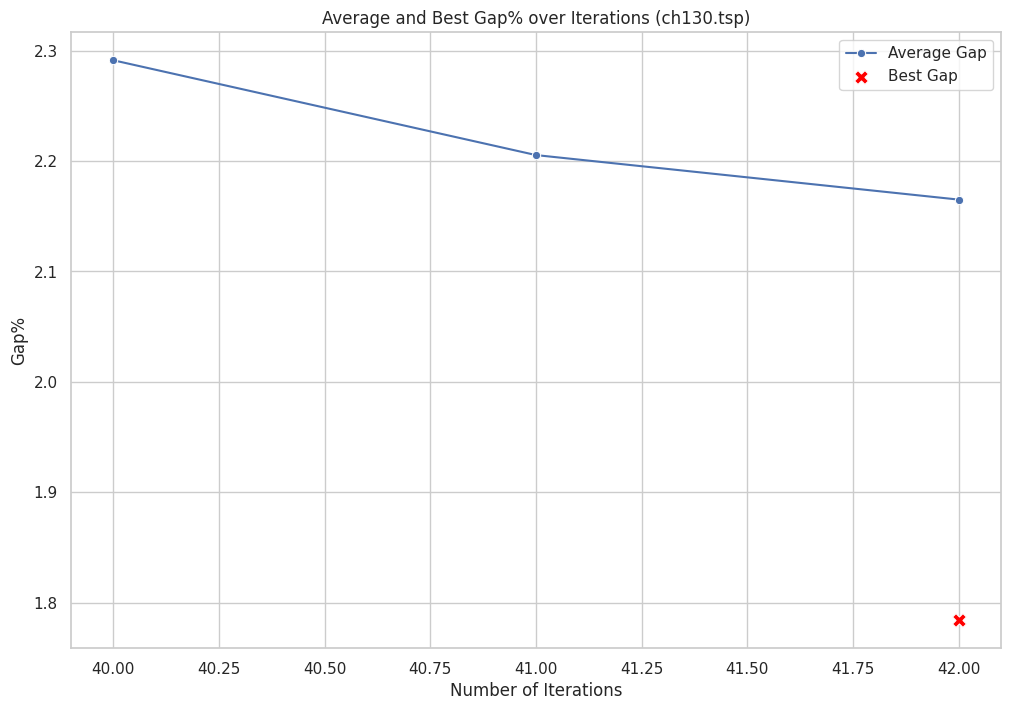

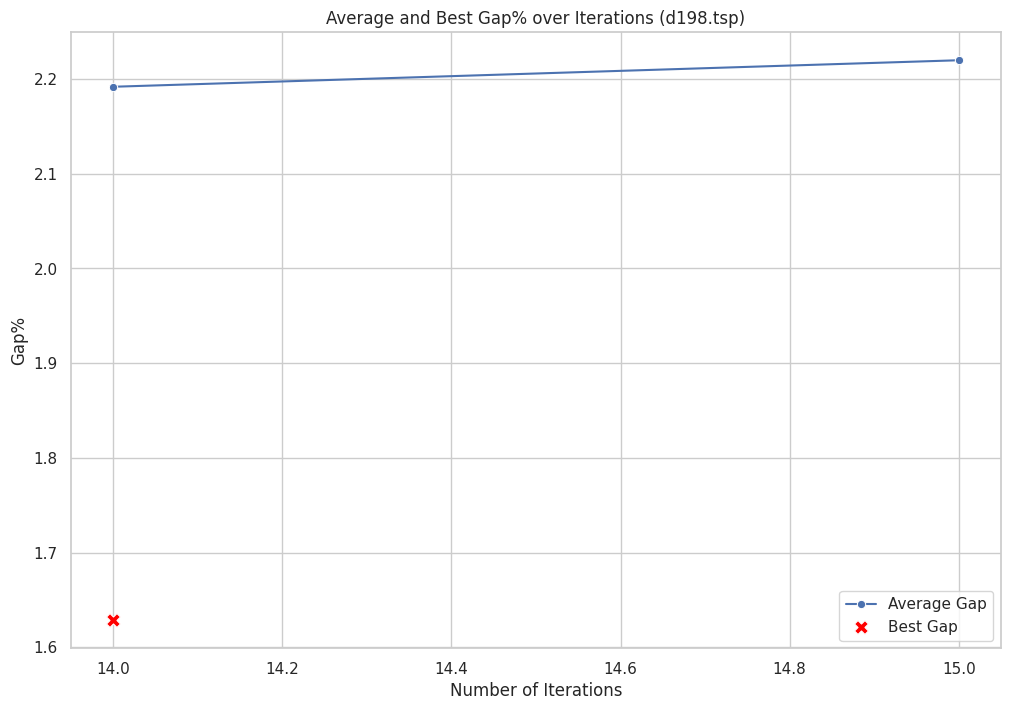

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of seaborn
sns.set(style="whitegrid")

# Group the DataFrame by 'Instance' and 'Number Iterations', calculate the average gap% and the minimum gap% for each group
avg_gap = df.groupby(['Instance', 'Number Iterations'])['Gap%'].mean().reset_index()
best_gap = df.loc[df.groupby('Instance')['Gap%'].idxmin()][['Instance', 'Number Iterations', 'Gap%']]

# Plotting for eil76.tsp
plt.figure(figsize=(12, 8))
eil76_data = avg_gap[avg_gap['Instance'] == 'eil76.tsp']
eil76_best_gap = best_gap[best_gap['Instance'] == 'eil76.tsp']

sns.lineplot(data=eil76_data, x='Number Iterations', y='Gap%', marker='o', linestyle='-', label='Average Gap')
sns.scatterplot(data=eil76_best_gap, x='Number Iterations', y='Gap%', marker='X', s=100, color='red', label='Best Gap')

plt.xlabel('Number of Iterations')
plt.ylabel('Gap%')
plt.title('Average and Best Gap% over Iterations (eil76.tsp)')
plt.legend()
plt.show()

# Plotting for ch130.tsp
plt.figure(figsize=(12, 8))
ch130_data = avg_gap[avg_gap['Instance'] == 'ch130.tsp']
ch130_best_gap = best_gap[best_gap['Instance'] == 'ch130.tsp']

sns.lineplot(data=ch130_data, x='Number Iterations', y='Gap%', marker='o', linestyle='-', label='Average Gap')
sns.scatterplot(data=ch130_best_gap, x='Number Iterations', y='Gap%', marker='X', s=100, color='red', label='Best Gap')

plt.xlabel('Number of Iterations')
plt.ylabel('Gap%')
plt.title('Average and Best Gap% over Iterations (ch130.tsp)')
plt.legend()
plt.show()

# Plotting for d198.tsp
plt.figure(figsize=(12, 8))
d198_data = avg_gap[avg_gap['Instance'] == 'd198.tsp']
d198_best_gap = best_gap[best_gap['Instance'] == 'd198.tsp']

sns.lineplot(data=d198_data, x='Number Iterations', y='Gap%', marker='o', linestyle='-', label='Average Gap')
sns.scatterplot(data=d198_best_gap, x='Number Iterations', y='Gap%', marker='X', s=100, color='red', label='Best Gap')

plt.xlabel('Number of Iterations')
plt.ylabel('Gap%')
plt.title('Average and Best Gap% over Iterations (d198.tsp)')
plt.legend()
plt.show()
